# 대회 개요
* Playground 대회
* 실제 데이터를 바탕으로 합성 데이터를 제공
* 제공된 feature를 바탕으로 소프트웨어 결함 여부를 검출
# 대회 기간
* 시작일 23/10/03
* 종료일 23/10/23
# 평가 지표
* area under the ROC curve
    * `from sklearn.metrics import roc_auc_score`
# 데이터 요약
* feature
    * int와 float형태의 22개의 feature를 제공함
* target
    * defects를 나타내는 boolean 값
        * 결함이 있으면 True
        * 결함이 없으면 False
* feature 정리
    ```
    1. loc              : numeric % McCabe's line count of code
    2. v(g)             : numeric % McCabe "cyclomatic complexity"
    3. ev(g)            : numeric % McCabe "essential complexity"
    4. iv(g)            : numeric % McCabe "design complexity"
    5. n                : numeric % Halstead total operators + operands
    6. v                : numeric % Halstead "volume"
    7. l                : numeric % Halstead "program length"
    8. d                : numeric % Halstead "difficulty"
    9. i                : numeric % Halstead "intelligence"
    10. e               : numeric % Halstead "effort"
    11. b               : numeric % Halstead
    12. t               : numeric % Halstead's time estimator
    13. lOCode          : numeric % Halstead's line count
    14. lOComment       : numeric % Halstead's count of lines of comments
    15. lOBlank         : numeric % Halstead's count of blank lines
    16. lOCodeAndComment: numeric
    17. uniq_Op         : numeric % unique operators
    18. uniq_Opnd       : numeric % unique operands
    19. total_Op        : numeric % total operators
    20. total_Opnd      : numeric % total operands
    21: branchCount     : numeric % of the flow graph
    22. defects         : {false,true} % module has/has not one or more  reported defects
    ```

# discussion, code 리뷰

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [33]:
# 데이터 둘러보기

In [34]:
data_path = '../../data/'

train = pd.read_csv(data_path+'train.csv', index_col='id')
test_df = pd.read_csv(data_path+'test.csv', index_col='id')
submission_df = pd.read_csv(data_path+'sample_submission.csv', index_col='id')
train_df = train.copy()

In [35]:
def vif(x):
    # vif 10 초과시 drop을 위한 임계값 설정
    thresh = 10
    # Filter method로 feature selection 진행 후 최종 도출 될 데이터 프레임 형성
    output = pd.DataFrame()
    # 데이터의 컬럼 개수 설정
    k = x.shape[1]
    # VIF 측정
    vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    for i in range(1,k):
        print(f'{i}번째 VIF 측정')
        # VIF 최대 값 선정
        a = np.argmax(vif)
        print(f'Max VIF feature & value : {x.columns[a]}, {vif[a]}')
        # VIF 최대 값이 임계치를 넘지 않는 경우 break
        if (vif[a] <= thresh):
            print('\n')
            for q in range(output.shape[1]):
                print(f'{output.columns[q]}의 vif는 {np.round(vif[q],2)}입니다.')
            break
        # VIF 최대 값이 임계치를 넘는 경우, + 1번째 시도인 경우 : if 문으로 해당 feature 제거 후 다시 vif 측정
        if (i == 1):
            output = x.drop(x.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        # VIF 최대 값이 임계치를 넘는 경우, + 1번째 이후 시도인 경우 : if 문으로 해당 feature 제거 후 다시 vif 측정
        elif (i > 1):
            output = output.drop(output.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    return(output)

In [36]:
X = train.iloc[:,:-1]
df = vif(X)
df.columns

1번째 VIF 측정
Max VIF feature & value : branchCount, 30.62102382338447
2번째 VIF 측정
Max VIF feature & value : total_Opnd, 28.71076448015364
3번째 VIF 측정
Max VIF feature & value : total_Op, 24.843521854143706
4번째 VIF 측정
Max VIF feature & value : n, 17.760236849351767
5번째 VIF 측정
Max VIF feature & value : t, 12.453516028671293
6번째 VIF 측정
Max VIF feature & value : e, 11.923508635443106
7번째 VIF 측정
Max VIF feature & value : lOComment, 10.336631584704023
8번째 VIF 측정
Max VIF feature & value : lOComment, 9.11357074117082


loc의 vif는 6.0입니다.
v(g)의 vif는 7.97입니다.
ev(g)의 vif는 3.14입니다.
iv(g)의 vif는 4.24입니다.
v의 vif는 5.26입니다.
l의 vif는 1.61입니다.
d의 vif는 4.45입니다.
i의 vif는 7.41입니다.
e의 vif는 3.0입니다.
t의 vif는 3.07입니다.
lOComment의 vif는 1.78입니다.
lOBlank의 vif는 4.34입니다.
locCodeAndComment의 vif는 1.16입니다.
uniq_Opnd의 vif는 9.11입니다.


Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'v', 'l', 'd', 'i', 'e', 't',
       'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Opnd'],
      dtype='object')

In [37]:
selected_columns = ['loc', 'v(g)', 'ev(g)', 'iv(g)', 'v', 'l', 'd', 'i', 'e', 't', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Opnd']

<Axes: >

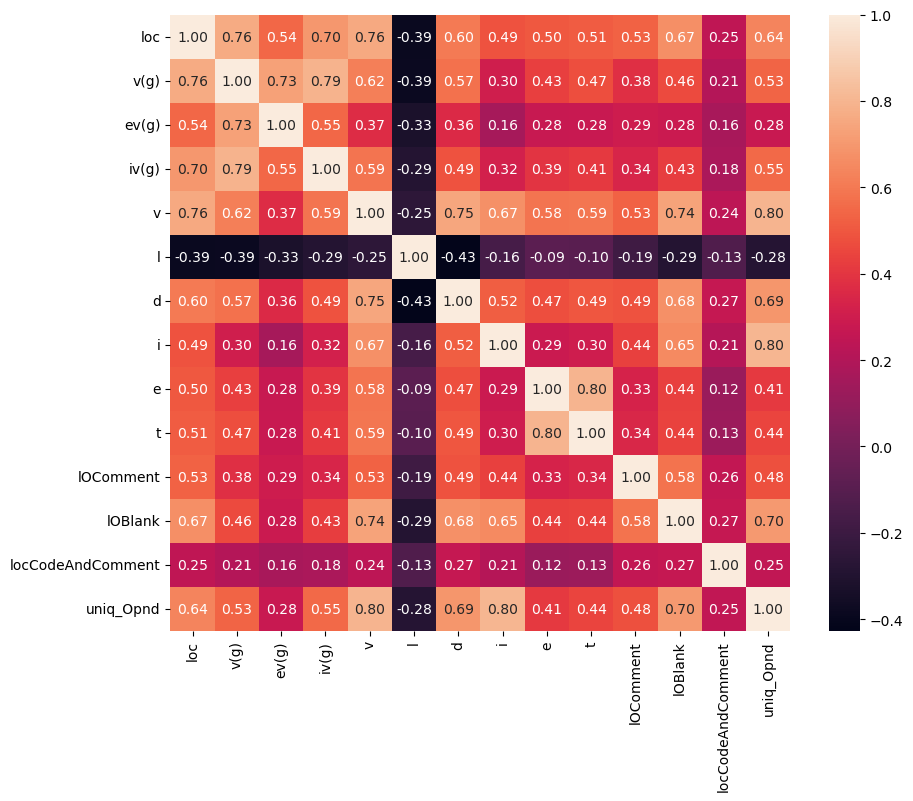

In [38]:
plt.figure(figsize=(10,8))
sns.heatmap(data=train[selected_columns].corr(), annot=True, fmt='.2f')